In [1]:
# Developed by: Ranjeet Kumar & Victor M. Zavala
# Implementation of scenario-based extensive form model for multi-stage stochastic programming
# A 24-hour battery charge-discharge planning problem to minimize energy cost and demand charge
# UW-Madison, 2017

if (!isdefined(:JuMP)) using JuMP end
if (!isdefined(:Ipopt)) using Ipopt end
if (!isdefined(:PyPlot)) using PyPlot end

# generate plots or not
makeplots = 1;

# construct scenario tree
nhours = 24;   # Number of hours we will plan the policy for
T = 6;         # Number of stages
dT = nhours/T; # Hours per stage
NS = 3;        # Number of scenarios of loads at each stage
S = 1:NS;      # Scenario set per stage
Stages = 1:T;  # Set of stages

Nodes = Vector(); # Vector to contain all node ids (numbers)
NodeStage = Dict(); # Dictionary: Keys: Node ids, Values: Stage number in which given node is present
StageNodes = Dict(); # Dictionary: Keys: Stage numbers, Values: Corresponding node ids at given stage
NodeChildren = Dict(); # Dictionary: Keys: Node ids, Values: Corresponding children node ids for that node

# Filling up all dictionaries to create scenario tree
curnodeid = 1; # Current node id
push!(Nodes,curnodeid);
NodeStage[curnodeid] = 1;
StageNodes[1] = [curnodeid];
NodeChildren[1] = Vector();
for t in 2:T
	StageNodes[t] = Vector();
	for n in StageNodes[t-1]
		for s in S
			curnodeid+=1;
			push!(NodeChildren[n],curnodeid);
			NodeChildren[curnodeid] = Vector();
			NodeStage[curnodeid] = t;
			push!(StageNodes[t],curnodeid);
			push!(Nodes,curnodeid);
    end
  end
end

function getLeafs(n) # This function gives the node ids at the last stage which originate from n at some past stage
  if NodeStage[n] == T
		return [n];
	else
       tmp = [];
		for c in NodeChildren[n]
    	append!(tmp,getLeafs(c));
    end
  end
	return tmp;
end

Scens = getLeafs(1); # Scens contains all node ids at last stage (originating from root node)
NScen = length(Scens); # Total number of scenarios in the tree (number of nodes in final stage of the tree)
ScensSeq = Dict(); # Local node ids at every stage for node in last stage 
for s in Scens
  ScensSeq[s] = Vector(T);
  ScensSeq[s][1] = 1;
end
j=1;
for t in T:-1:2
  s = Scens[1];
  while(s<=Scens[end])
    for ss in 1:NS
      for i in 1:NS^(T-t)
        ScensSeq[s][t] = ss;
        s = s + 1;
        j=j+1
      end
    end
  end
end

# display some quantities to see tree structure
#print(Nodes)    # ids for nodes
#print(Stages)   # ids for stages
#print(StageNodes[1]) # stage of node 1
#print(StageNodes[6]) # stage of node 6
#print(getLeafs(1) # get leafs of node 1
#print(getLeafs(364)) # get leafs of node 364
#ScensSeq[122]

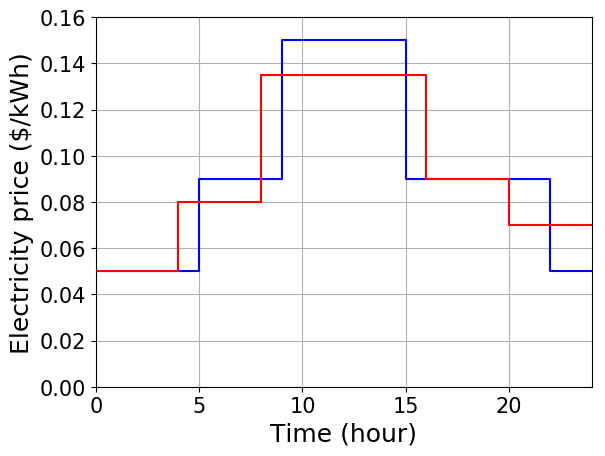

In [2]:
# Battery model Parameters
ebat_max = 500;	            # Battery capacity, kWh
P_max = 1000;	            # Maximum power, kW
ebat0 = ebat_max;		    # Initial State of charge
rampmin = -0.5*P_max;	    # Lower bound for ramp discharge, kW/hr
rampmax = 0.5*P_max;  	    # Upper bound for ramp discharge, kW/hr
terminalSOC = 0.5*ebat_max; # Terminal condition on SOC (at the end of day)
demandrate = 4.15           # demand charge over horizon $/kW

# Electricity Price data
eprice = [0.05 0.05 0.05 0.05 0.05 0.09 0.09 0.09 0.09 0.15 0.15 0.15 0.15 0.15 0.15 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.05 0.05];

# Price data averaged over stages (4-hour intervals)
eprice_st = Vector(T); # Define an empty matrix
for i in 1:T
  eprice_st[i] = mean(eprice[(i-1)*4+1:i*4]);
end

# Stagewise Electricity Price Data
#eprice_st = [0.05; 0.08; 0.11; 0.13; 0.10; 0.06]

if makeplots == 1
# Plot to visualize load profile scenarios
figure()
grid()
plot(0:nhours, push!(eprice[1,:], eprice[1,end]), drawstyle="steps-post", color="blue", linewidth=1.5) # Hourly price plot
plot(0:dT:nhours, push!(eprice_st, eprice_st[end]), drawstyle="steps-post", color="red", linewidth=1.5) # Stagewise average price plot
xlim(0,nhours)
ylim(0,0.16)
xlabel("Time (hour)", size=18)
ylabel("Electricity price (\$/kWh)", size=18)
tick_params(labelsize=15)
savefig("energy_price_profile.pdf")
end

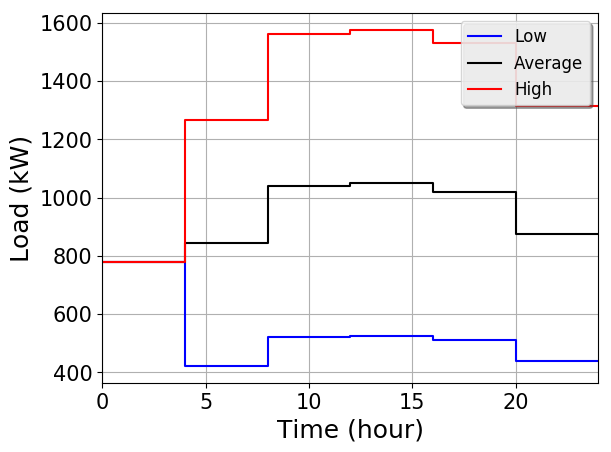

sys:1: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python2.7/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


In [3]:
# Hourly load data
meanload = [803.689 779.355 781.096 757.36 780.282 801.882 865.736 927.623 974.548 1041.19 1062.17 1083.26 1062.25 1061.99 1038.16 1039.47 1040.53 1042.99 1018.81 978.295 932.221 892.035 849.88 826.602];
load_scens = [0.50*meanload' meanload' 1.50*meanload']; # three scenarios of load profile: low, average and high

# Load data averaged over stages (4-hour intervals)
L = Matrix(T,NS); # Define an empty matrix
for s in 1:NS
  L[1,s] = mean(meanload[1:4]);
  for i in 2:T
    L[i,s] = mean(load_scens[(i-1)*4+1:i*4,s]);
  end
end

# plot time profiles load
figure()
hold(true)
grid()
plot(0:dT:nhours, push!(L[:,1], L[end,1]), drawstyle="steps-post", color="blue", linewidth=1.5, label="Low")
plot(0:dT:nhours, push!(L[:,2], L[end,2]), drawstyle="steps-post", color="black", linewidth=1.5, label="Average")
plot(0:dT:nhours, push!(L[:,3], L[end,3]), drawstyle="steps-post", color="red", linewidth=1.5, label="High")
xlim(0,nhours)
xlabel("Time (hour)", size=18)
ylabel("Load (kW)", size=18)
tick_params(labelsize=15)
legend(loc="upper right",fancybox="True", shadow="True", fontsize = 12)
savefig("load_profile_scenarios.pdf")

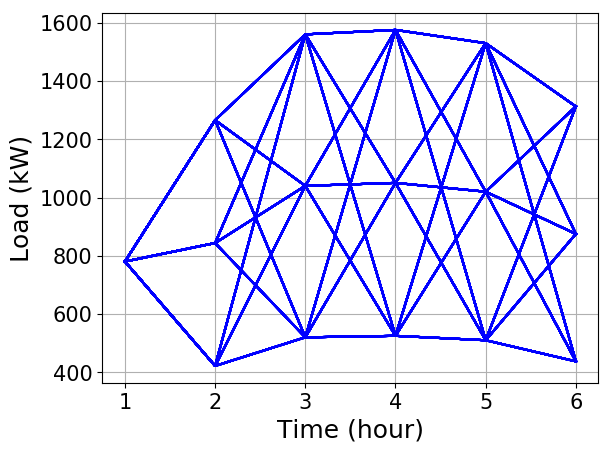

In [20]:
# plot load tree pathways
figure()
grid()
Lmat=zeros(T,length(Scens))
for t in Stages 
    idx=0;
    for s in Scens 
        idx=idx+1
        Lmat[t,idx]=L[t,ScensSeq[s][t]]
    end
end
for s in 1:length(Scens)
plot(1:T,Lmat[:,s],color="blue")        
end
xlabel("Time (hour)", size=18)
ylabel("Load (kW)", size=18)
tick_params(labelsize=15)
savefig("load_profile_tree.pdf")

In [4]:
######################################################
# MultiStage Stochastic Programming Model

m = Model(solver = IpoptSolver())
@variable(m, 0 <= ebat[Stages,Scens] <= ebat_max) # Energy level of battery (SOC) at stage t
@variable(m, -P_max <= P[Stages,Scens] <= P_max) # Net power (discharging is positive, charging is negative) at stage t
@variable(m, d[Stages,Scens] >= 0) # Unmet load at stage t
@variable(m, D[Scens])
@variable(m, energycost[Scens])
@variable(m, demandcost[Scens])

@objective(m, Min, sum(energycost[s]+demandcost[s] for s in Scens))
# Inital SOC of battery in all scenarios is ebat0
@constraint(m, Stage1_SOC[t in Stages[1], s in Scens], ebat[t,s] == ebat0 - P[t,s]*dT)
# Energy balance for stages 2 to 6
@constraint(m, EnergyBalance[t in Stages[2:end], s in Scens], ebat[t,s] == ebat[t-1,s] - P[t,s]*dT)
# Terminal condition
@constraint(m, TerminalSOC[t in Stages[end], s in Scens], ebat[t,s] >= terminalSOC)
# Power required to be purchased from grid = d[t,s]
@constraint(m, DemandfromGrid[t in Stages, s in Scens], P[t,s] + d[t,s] == L[t,ScensSeq[s][t]])
# Demand charge
@constraint(m, DemandCharge[s in Scens, t in Stages], D[s] >= d[t,s])
# Energy Cost calculation for each scenario
@constraint(m, EnergyCost[s in Scens], energycost[s] == sum((1/(NS)^t)*eprice_st[t]*d[t,s]*dT for t in Stages))
# Demand charge cost calculation for each scenario
@constraint(m, DemandCost[s in Scens], demandcost[s] == demandrate*D[s])

# Nonanticipativity: Decisions have to be same in all scenarios in the set S(n) [getLeafs(n)]
@constraint(m, Nonanticipativity[t in Stages[1:end-1], 
                                 n in StageNodes[t], 
                                 s in getLeafs(n), 
                                s1 in getLeafs(n)[1]], P[t,s] == P[t,s1])

# For two-stage use this relaxed nonanticipativity constraint
#@constraint(m, Nonanticipativity[t in Stages[1:1], 
#                                 n in StageNodes[t], 
#                                 s in getLeafs(n), 
#                                s1 in getLeafs(n)[1]], P[t,s] == P[t,s1])

status = solve(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    11543
Number of nonzeros in inequality constraint Jacobian.:     3159
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     5103
                     variables with only lower bounds:     1458
                variables with lower and upper bounds:     2916
                     variables with only upper bounds:        0
Total number of equa

:Optimal

In [5]:
# collect results
ebat = Matrix(T,NScen)
P = Matrix(T,NScen)
d = Matrix(T,NScen)
D = Vector(NScen)
energycost = Vector(NScen)
demandcost = Vector(NScen)

for t in 1:T
  ss = 1;
  for s in Scens
    ebat[t,ss] = getvalue(getvariable(m,:ebat)[t,s]);
    P[t,ss] = getvalue(getvariable(m,:P)[t,s]);
    d[t,ss] = getvalue(getvariable(m,:d)[t,s]);
    ss = ss + 1;
  end
end

ss = 1;
for s in Scens
	D[ss] = getvalue(getvariable(m,:D)[s])
  energycost[ss] = getvalue(getvariable(m,:energycost)[s]);
  demandcost[ss] = getvalue(getvariable(m,:demandcost)[s]);
  ss = ss + 1;
end
obj_val = getobjectivevalue(m);

println("Expected total cost = $(obj_val)")

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in getvariable(::JuMP.Model, ::Vararg{Any,N}) at ./deprecated.jl:30
 in macro expansion; at ./In[5]:12 [inlined]
 in anonymous at ./<missing>:?
 in include_string(::String, ::String) at ./loading.jl:441
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /opt/julia_packages/.julia/v0.5/IJulia/src/execute_request.jl:156
 in eventloop(::ZMQ.Socket) at /opt/julia_packages/.julia/v0.5/IJulia/src/eventloop.jl:8
 in (::IJulia.##13#19)() at ./task.jl:360
while loading In[5], in expression starting on line 9


Expected total cost = 1.4085892468897437e6


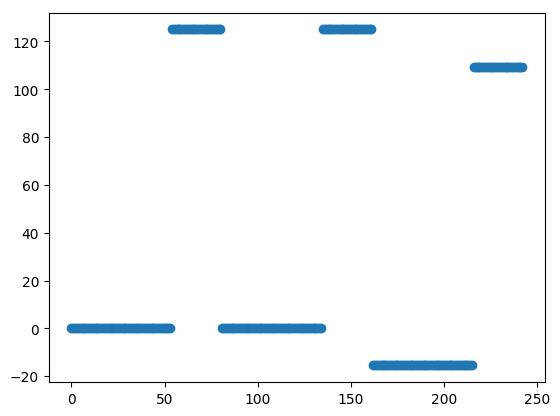

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdea536e190>

In [6]:
# visualize power policy
plot(P[3,:],"o")

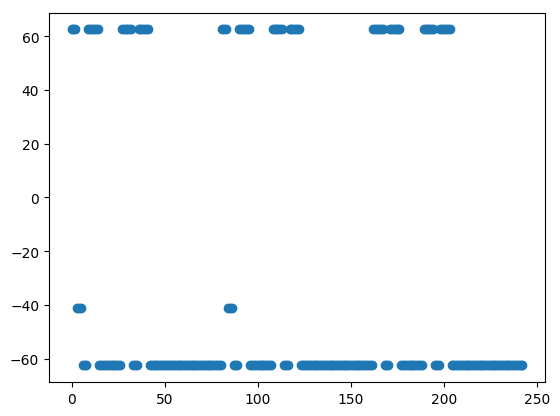

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdea57fa950>

In [7]:
# visualize power policy
plot(P[6,:],"o")

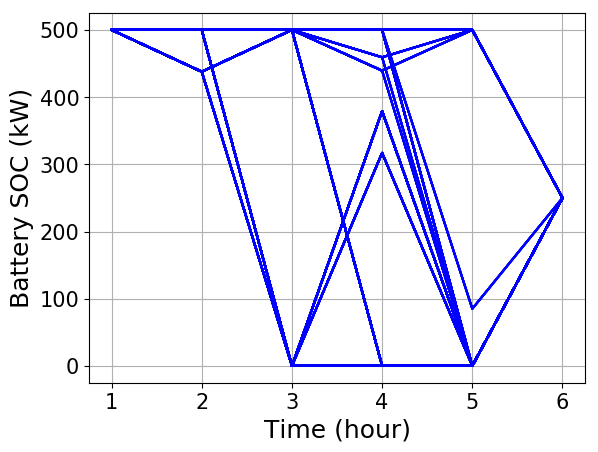

In [9]:
# plot state tree pathways
figure()
grid()
for s in 1:length(Scens)
plot(1:T,ebat[:,s],color="blue")        
end
xlabel("Time (hour)", size=18)
ylabel("Battery SOC (kW)", size=18)
tick_params(labelsize=15)
savefig("state_profile_tree.pdf")

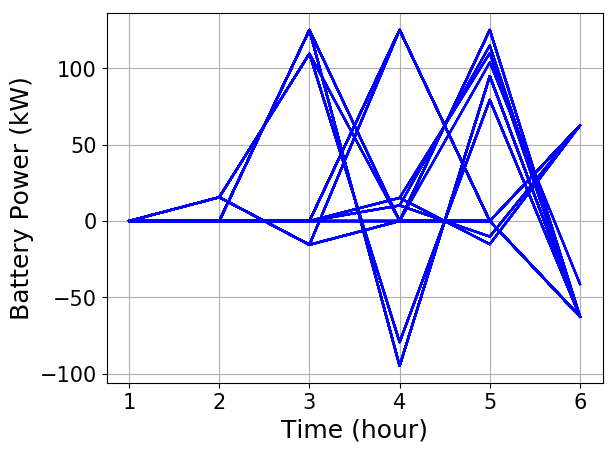

In [10]:
# plot control tree pathways
figure()
grid()
for s in 1:length(Scens)
plot(1:T,P[:,s],color="blue")        
end
xlabel("Time (hour)", size=18)
ylabel("Battery Power (kW)", size=18)
tick_params(labelsize=15)
savefig("control_profile_tree.pdf")